In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#import warnings
#warnings.filterwarnings("ignore")

In [2]:
from matplotlib import colors as colors

cmap_data = [(0, 'navy'),(0.1, 'blue'),(0.2,'DeepSkyBlue'),
             (0.3,'aquamarine'),(0.4,'PaleGreen'),(0.45,'moccasin'),
             (0.55,'moccasin'),(.6,'yellow'),(.7,'DarkOrange'),
             (.8,'red'),(1.0,'DarkRed')]
cmap = colors.LinearSegmentedColormap.from_list('correlationcolorscale', cmap_data)
plt.register_cmap('correlationcolorscale', cmap)

In [3]:
# CPC Precipitation

ttypes = ['RETRO','REALTIME']
for ttype in ttypes:
    url=f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.GLOBAL/.v1p0/.{ttype}/.rain/monthlyAverage/data.nc'
    if os.path.exists(f'data/CPC_{ttype}.nc'):
        continue
    os.system(f'wget {url}; mv data.nc data/CPC_{ttype}.nc')

ds = xr.open_mfdataset('data/CPC_*.nc',decode_times=False,concat_dim='T').rename({'T':'time'}).sel(Y=slice(-10,70))
ds.coords['X'] = (ds.coords['X'] - 30) % 360 + 30; ds = ds.sortby('X')
ds['time'] = pd.date_range('1979-01',periods=len(ds.time), freq='MS').shift(15,freq='D')
ds = ds.sel(time=slice('1979-01','2021-02'))

ds_rain_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 22 times more chunks
  return self.array[key]


In [4]:
# NCEP-NCAR SST

vars = ['temp','LAND','ICEC']
for var in vars:
    url=f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Diagnostic/.surface/.{var}/data.nc'
    if os.path.exists('data/CDAS1_{var}.nc'):
        continue
    os.system(f'wget {url}; mv data.nc data/CDAS1_{var}.nc')

ds = xr.open_mfdataset('data/CDAS1_*.nc',decode_times=False).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
#print(ds.LAND.dropna(dim='time').drop('time').squeeze())

ds['LAND'] = ds.LAND.dropna(dim='time').drop('time').squeeze()

ds.coords['X'] = (ds.coords['X'] - 30) % 360 + 30 ; ds = ds.sortby('X')
ds['temp'] = ds.temp.where(ds.ICEC<=0).where(ds.LAND==0)
ds['time'] = pd.date_range('1949-01',periods=len(ds.time), freq='MS').shift(15,freq='D')
ds = ds.sel(time=slice('1979-01','2021-02'))
ds_temp_anom = ds.groupby('time.month').apply(lambda x: x - x.mean('time'))

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


In [5]:
# NCEP-NCAR Geopotential height at 200mb

if not os.path.exists('data/CDAS_Z200.nc'):
    url = f'http://iridl.ldeo.columbia.edu/expert/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/P/200/VALUE/P/removeGRID/data.nc'
    os.system(f'wget {url}; mv data.nc data/CDAS_Z200.nc')

dsz = xr.open_dataset('data/CDAS_Z200.nc',decode_times=False).sortby('Y').rename({'T':'time'}).sel(Y=slice(-10,70))
dsz.coords['X'] = (dsz.coords['X'] - 30) % 360 + 30 ; dsz = dsz.sortby('X')
dsz['time'] = pd.date_range('1949-01',periods=len(dsz.time), freq='MS').shift(15,freq='D')
dsz = dsz.sel(time=slice('1979-01','2021-02'))
ds_z200_anom = dsz.groupby('time.month').apply(lambda x: x - x.mean('time'))

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/python/anaconda3/envs/pa

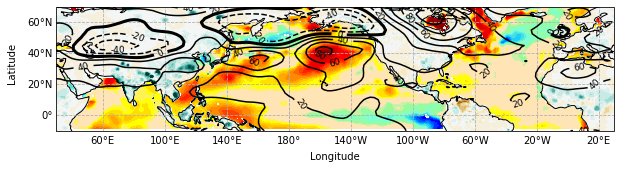

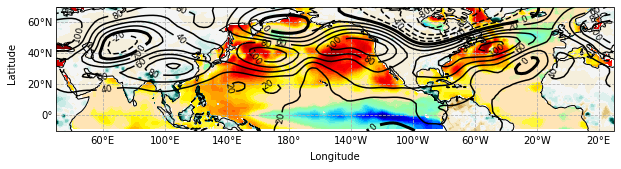

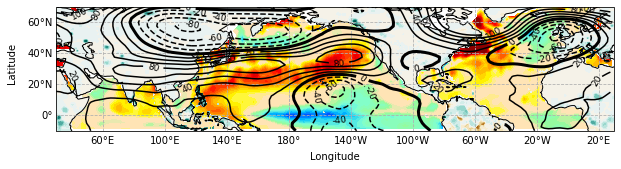

In [6]:
# T 3 boxAverage, starting with 3rd month (March 1979)
ds_rain = ds_rain_anom.rain[2:].coarsen(time=3,boundary='trim').mean()
ds_temp = ds_temp_anom.temp[2:].coarsen(time=3,boundary='trim').mean()
ds_z200 = ds_z200_anom.phi[2:].coarsen(time=3,boundary='trim').mean()

for month in ['2020-07','2020-10','2021-01']:
    fig = plt.figure(figsize=(10,5))

    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=210))
    ax.set_extent([30, 390, -10,  70], crs=ccrs.PlateCarree())

    temp = ds_temp.sel(time=f'{month}').squeeze().drop(['time'])
    rain = ds_rain.sel(time=f'{month}').squeeze().drop(['time'])
    z200 = ds_z200.sel(time=f'{month}').squeeze().drop(['time'])
    
    cb1 = temp.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
    cb2 = rain.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10,vmax=10, levels=21, cmap='BrBG', add_colorbar=False)
    CS  = z200.plot.contour (ax=ax, colors= 'k', transform=ccrs.PlateCarree(),zorder=10, vmin=-100,vmax=100,levels=11)
    CS.collections[5].set_linewidth(3) # plot the zero line thicker

    ax.clabel(CS, inline=1, fontsize=9, fmt='%1.0f')
    ax.add_feature(cfeature.COASTLINE)
    
    ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
    ax.text(0.5, -0.25, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)
    
    gl = ax.gridlines(draw_labels=True, alpha=1.0, xlocs=np.arange(-180,181,40), ylocs=np.arange(0,70,20), linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # do some cropping of the eps file so that we can use it in latex
    plt.savefig('plot.eps')
    os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/overlay_{month}.eps')

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


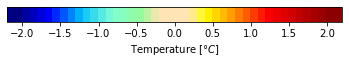

In [7]:
# plot just colorbar:
cb = ds_temp[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, levels=41, cmap='correlationcolorscale', add_colorbar=False)
plt.gca().set_visible(False)
cbar = plt.colorbar(cb, extendrect = True, label=r'Temperature [$\degree C$]', orientation='horizontal')
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/temp-colorbar.eps');

/usr/local/python/anaconda3/envs/pangeo-Jul2020/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


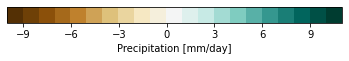

In [8]:
cb = ds_rain[0].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-10,vmax=10, levels=21, cmap='BrBG', add_colorbar=False)
plt.gca().set_visible(False)
cbar = plt.colorbar(cb, extendrect = True, label=r'Precipitation [mm/day]', orientation='horizontal')
plt.savefig('plot.eps')
os.system(f'/usr/bin/ps2eps -B -C < plot.eps > eps/rain-colorbar.eps');